In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('train.csv')

In [3]:
df = df.dropna()

In [4]:
df.columns

Index(['Unnamed: 0', ' Destination Port', 'Bwd Packet Length Max',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std',
       ' Max Packet Length', ' Min Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance',
       ' Avg Bwd Segment Size', ' Average Packet Size', ' Label'],
      dtype='object')

In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Label' column
df[' Label'] = label_encoder.fit_transform(df[' Label'])

# Print the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{0: 0, 1: 1}


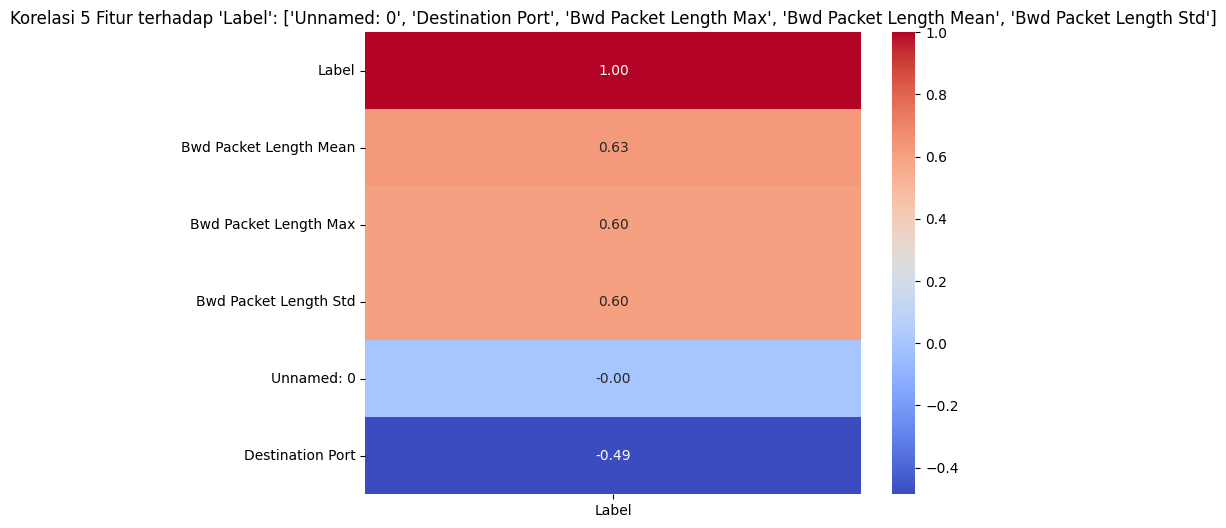

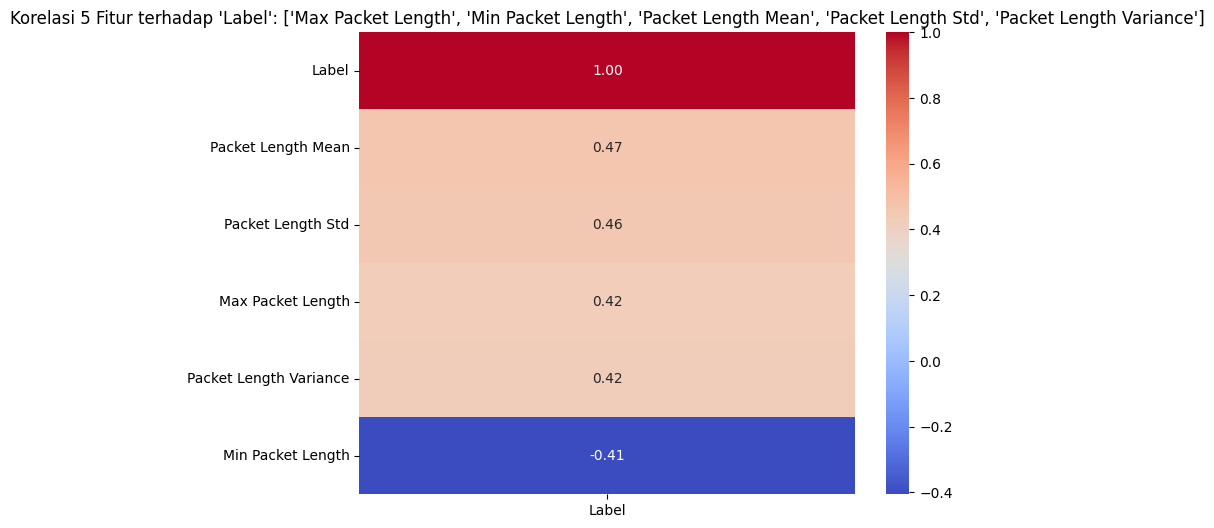

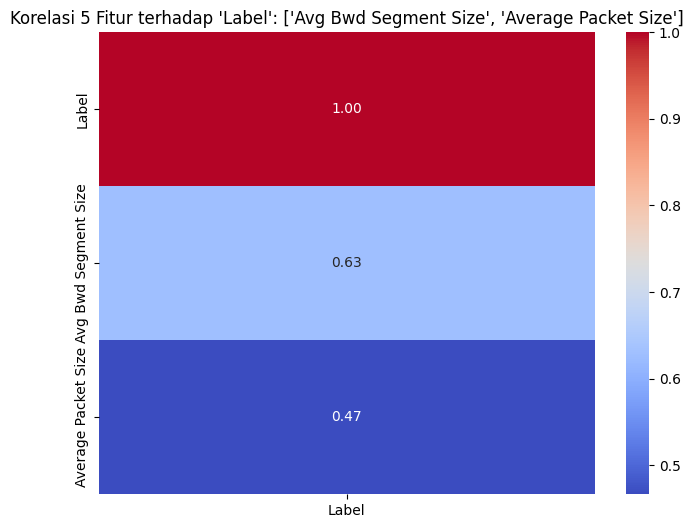

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Bersihkan nama kolom dengan menghapus spasi ekstra di awal/akhir
df.columns = df.columns.str.strip()

# Daftar kolom (fitur) selain 'Label'
features = [col for col in df.columns if col != 'Label']

# Membagi fitur menjadi kelompok per 5
chunk_size = 5
feature_chunks = [features[i:i + chunk_size] for i in range(0, len(features), chunk_size)]

# Plot heatmap untuk setiap kelompok
for chunk in feature_chunks:
    subset = chunk + ['Label']  # Tambahkan kolom 'Label'
    corr = df[subset].corr()    # Hitung korelasi untuk subset
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr[['Label']].sort_values(by='Label', ascending=False), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f"Korelasi 5 Fitur terhadap 'Label': {chunk}")
    plt.show()


In [7]:

df = df[['Destination Port', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Max Packet Length', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Avg Bwd Segment Size', 'Average Packet Size', 'Label']]

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


# Pisahkan fitur dan label
X_train = df.drop(' Label', axis=1)
y_train = df[' Label']





KeyError: "[' Label'] not found in axis"

In [20]:
y_train.unique()

array([1, 0], dtype=int64)

In [13]:
# Load data dengan memastikan konsistensi kolom
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)

In [15]:
df_train.columns

Index(['Row_Number', ' Destination Port', 'Bwd Packet Length Max',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std',
       ' Max Packet Length', ' Min Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance',
       ' Avg Bwd Segment Size', ' Average Packet Size', ' Label'],
      dtype='object')

In [21]:
df_train_1= df_train.drop('Row_Number', axis=1)

In [23]:
df_train.columns


Index(['Row_Number', 'Destination Port', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Max Packet Length',
       'Min Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'Avg Bwd Segment Size', 'Average Packet Size',
       'Label'],
      dtype='object')

Kolom di X_train: Index(['Destination Port', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Max Packet Length', 'Min Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Avg Bwd Segment Size', 'Average Packet Size'],
      dtype='object')
Kolom di X_test: Index(['Destination Port', 'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Max Packet Length', 'Min Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'Avg Bwd Segment Size', 'Average Packet Size'],
      dtype='object')
Shape of X_train_reshaped: (156594, 1, 11)
Shape of X_test_reshaped: (45149, 1, 11)


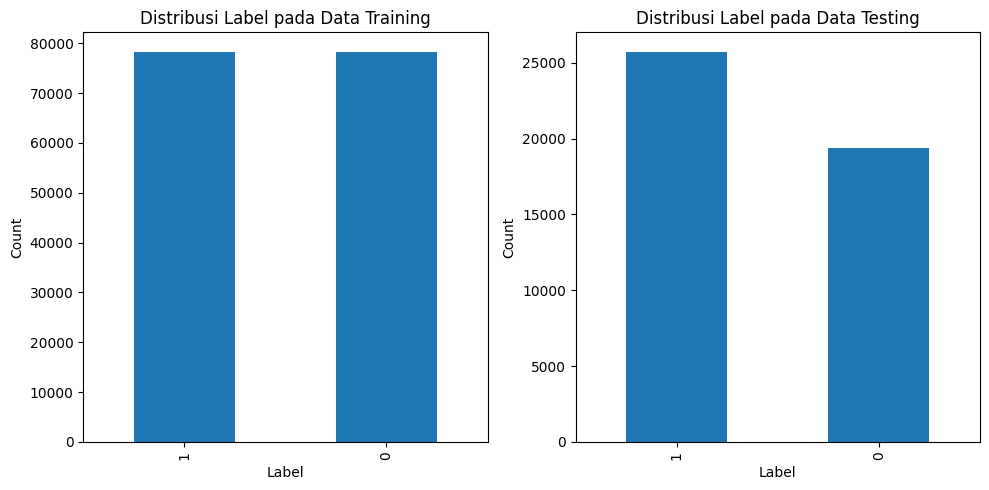

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Bersihkan nama kolom dengan menghapus spasi ekstra di awal/akhir
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Pisahkan fitur dan label
X_train = df_train[[ 'Destination Port', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Max Packet Length',
       'Min Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'Avg Bwd Segment Size', 'Average Packet Size']]
y_train = df_train['Label']

X_test = df_test.drop('Label', axis=1)
y_test = df_test['Label']

# Pastikan kolom fitur konsisten
print("Kolom di X_train:", X_train.columns)
print("Kolom di X_test:", X_test.columns)

# Pastikan tidak ada kolom yang hilang
missing_in_test = set(X_train.columns) - set(X_test.columns)
missing_in_train = set(X_test.columns) - set(X_train.columns)

if missing_in_test or missing_in_train:
    raise ValueError(f"Kolom tidak konsisten!\nMissing in test: {missing_in_test}\nMissing in train: {missing_in_train}")

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit scaler pada data training saja
X_train_scaled = scaler.fit_transform(X_train)

# Transform data test dengan scaler yang sama
X_test_scaled = scaler.transform(X_test)

# Reshape data menjadi bentuk [samples, timesteps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Tampilkan shape dari data yang telah di-reshape
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

# Plot distribusi label
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar')
plt.title('Distribusi Label pada Data Training')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar')
plt.title('Distribusi Label pada Data Testing')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L1L2

In [36]:
from keras.layers import Reshape

model1 = Sequential(
    [
        #Layer1
        LSTM(128, input_shape=(X_train_reshaped .shape[1], X_train_reshaped .shape[2]), return_sequences=True),
        Dropout(0.2),
        Dense(64),
        Dropout(0.2),
        #Layer2
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        Dense(32, activation='tanh'),
        Dropout(0.2),
        #Layer3
        Dense(1, activation='sigmoid')
    ]
)
model1.summary()

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 128)         │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1, 1)           │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,073 (449.50 KB)

 Trainable params: 115,073 (449.50 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
from keras.optimizers import Adam

# Compile the model with Adam optimizer and a learning rate of 0.00001
model1.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
weight = {0: 1.0, 1: 1.0}

train = model1.fit(X_train_reshaped ,y_train, epochs=10, batch_size=32, validation_split=0.2)
train

Epoch 1/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.7552 - loss: 0.5802 - val_accuracy: 0.7507 - val_loss: 0.3240
Epoch 2/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8024 - loss: 0.3030 - val_accuracy: 0.8785 - val_loss: 0.2501
Epoch 3/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8751 - loss: 0.2429 - val_accuracy: 0.9291 - val_loss: 0.1915
Epoch 4/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9244 - loss: 0.1897 - val_accuracy: 0.9413 - val_loss: 0.1532
Epoch 5/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9334 - loss: 0.1635 - val_accuracy: 0.9470 - val_loss: 0.1372
Epoch 6/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9366 - loss: 0.1524 - val_accuracy: 0.9494 - val_loss: 0.1276
Epoch 7/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9394 - loss: 0.1456 - val_accuracy: 0.9499 - val_loss: 0.1206
Epoch 8/10
3915/3915 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9430 - loss: 0

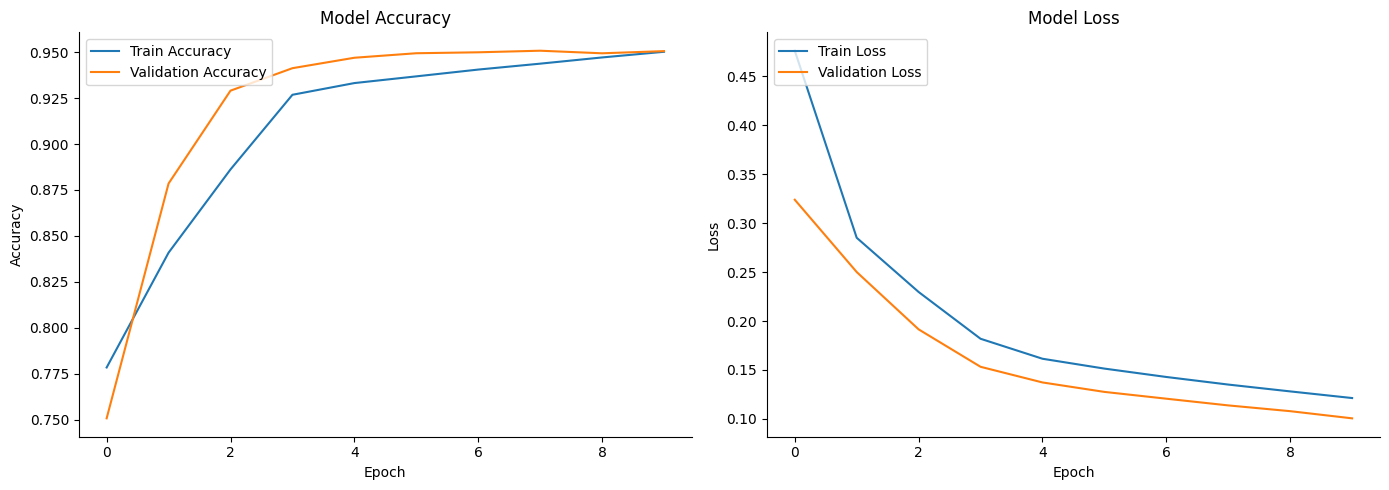

In [53]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Train Accuracy')
plt.plot(train.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
sns.despine()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Train Loss')
plt.plot(train.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
sns.despine()

plt.tight_layout()
plt.show()

In [54]:
from sklearn.metrics import f1_score

# Lakukan prediksi menggunakan model yang telah dilatih
y_pred = model1.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int)



1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


ValueError: Must pass 2-d input. shape=(45149, 1, 1)

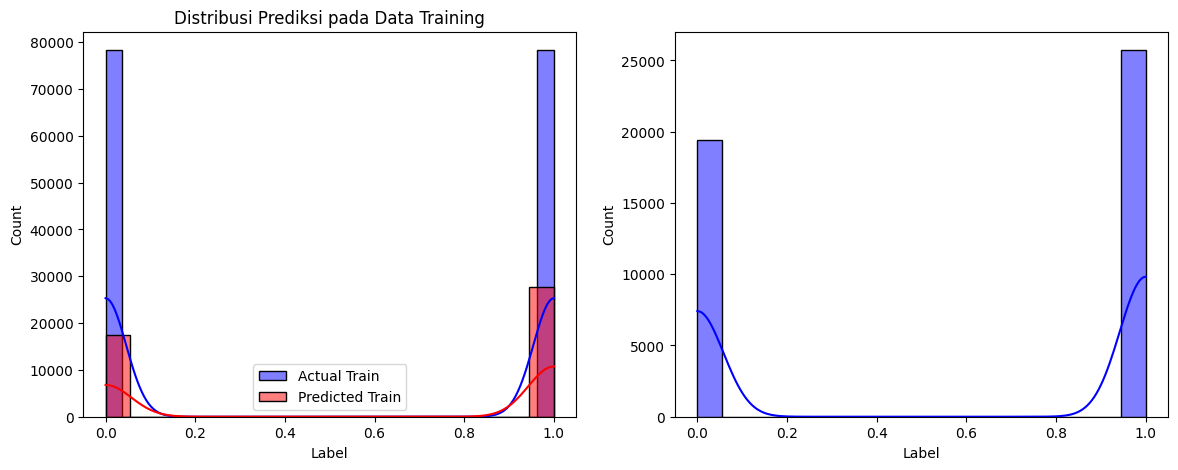

In [56]:
y_pred

array([[[0]],

       [[0]],

       [[1]],

       ...,

       [[0]],

       [[1]],

       [[0]]])

In [57]:
y_pred = np.squeeze(y_pred)  # Atau gunakan reshape(-1)

# Menghitung F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

F1 Score: 0.9626910398561582


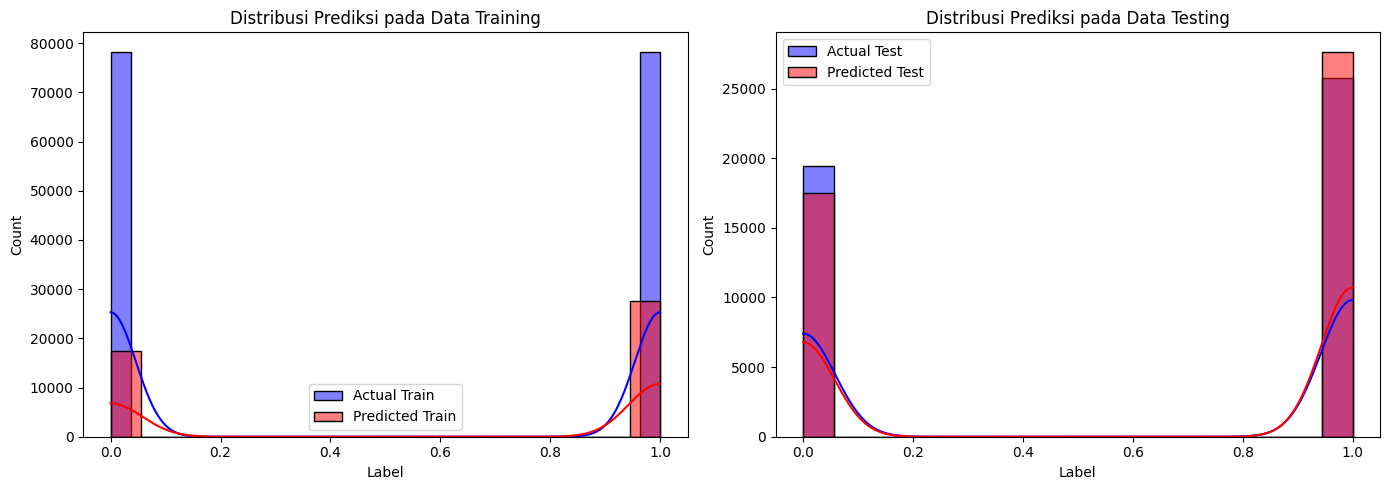

In [58]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot distribusi prediksi pada data training
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, color='blue', label='Actual Train')
sns.histplot(y_pred_classes, kde=True, color='red', label='Predicted Train')
plt.title('Distribusi Prediksi pada Data Training')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend()

# Plot distribusi prediksi pada data testing
plt.subplot(1, 2, 2)
sns.histplot(y_test, kde=True, color='blue', label='Actual Test')
sns.histplot(y_pred, kde=True, color='red', label='Predicted Test')
plt.title('Distribusi Prediksi pada Data Testing')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
from sklearn.metrics import classification_report

# Prediksi model

y_pred_classes = (y_pred > 0.5).astype(int)  # Untuk kasus biner

# Laporan klasifikasi
report = classification_report(y_test, y_pred_classes, target_names=['Kelas 0', 'Kelas 1'])
print(report)


              precision    recall  f1-score   support

     Kelas 0       1.00      0.90      0.95     19417
     Kelas 1       0.93      1.00      0.96     25732

    accuracy                           0.96     45149
   macro avg       0.96      0.95      0.95     45149
weighted avg       0.96      0.96      0.96     45149

